# Documentation and acknowledgement

**HOW TO USE**

If you would like to use this program, first download and upload the specified dataset into Gdrive to the correct folder or directly into colab. Most of the program is automatic.

Run all the required components beforehand to initialize the program

Some of them will take a really long time so be patient (Ex: Installing PIP, getting csv, etc.)

The program will take around 40 minutes total to complete if you iterate over the big data


Dataset:
By: Marlesson Santana
Link: https://www.kaggle.com/marlesson/myanimelist-dataset-animes-profiles-reviews 

# Loading libraries and mounting data from GDrive (Run only once)

In [ ]:
# Prophet PIP download
from IPython.display import clear_output 
!pip install prophet
clear_output()

In [ ]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from google.colab import drive
import re
import sklearn.metrics as metrics
import datetime
import scipy.stats as stats

In [ ]:
# Mounting Google Drive
try:
  drive.mount('/content/drive')
except MessageError:
  print('Not mounting GDrive, please upload the .csv files')
else:
  print('Mounting successful')

Mounted at /content/drive
Mounting successful


In [ ]:
# Try importing dataset from mounted GDrive or reset dataset
try:
  Anime = pd.read_csv('/content/drive/MyDrive/Data Sci Files/animes.csv')
  Reviews = pd.read_csv('/content/drive/MyDrive/Data Sci Files/reviews.csv')
except FileNotFoundError:
  try:
    Anime = pd.read_csv('animes.csv')
    Reviews = pd.read_csv('reviews.csv')
  except FileNotFoundError:
    print("Error: files not found in Google Drive or uploaded to Colab")
  else:
    print("Succesfully uploaded")
else:
  print("Succesfully mounted")

Succesfully mounted


# Functions vault (Run only once)

In [ ]:
# Cleaning broken data function
def CleanNaN(df):
  df.replace('Not available', np.nan, inplace=True)
  df.replace('', np.nan, inplace=True)
  df.dropna(inplace=True)
  return df

In [ ]:
# Prophet plotting and graphing for single dataset
# Days indicate how much days ahead the prophet algorithm will predict (1 year = 365 days)
def SingleProphet(df, days):
  m = Prophet()
  m.fit(df)
  future = m.make_future_dataframe(periods = days)
  forecast = m.predict(future)
  return m, forecast

In [ ]:
# Convertion to datetime
def convertDateTime(date):
  try:
    date = datetime.datetime.strptime(date, "%b%d,%Y")
  except ValueError:
    try:
      date = datetime.datetime.strptime(date, "%b,%Y")
    except ValueError:
      date = datetime.datetime.strptime(date, "%Y")
  return date

In [ ]:
# Evaluation methods of time series model
def RMSE(prediction, actual):
  return metrics.mean_squared_error(actual, prediction, squared = False)
def MSE(prediction, actual):
  return metrics.mean_squared_error(actual, prediction)
def MAE(prediction, actual):
  return metrics.mean_absolute_error(actual, prediction)
def MAPE(prediction, actual):
  return metrics.mean_absolute_percentage_error(actual, prediction)*100
def Evaluate(prediction,actual):
  print("Evluations:")
  print("Root Mean Squared Error: " + str(RMSE(prediction,actual)))
  print("Normalized RMSE: " + str(RMSE(prediction,actual)/(max(actual)-min(actual))))
  print("Mean Squared Error: " + str(MSE(prediction,actual)))
  print("Mean Absolute Error: " + str(MAE(prediction,actual)))
  print("Mean Absolute Percentage Error: " + str(MAPE(prediction, actual)) + "%")

In [ ]:
# Breaking down a years worth of reviews
def SeasonalBreakdown(df, year, title):
  Seasons = ["Winter","Spring","Summer","Autumn","Winter2"]
  SeasonalDict = {}
  x = 0
  Total = df.copy()
  Total = Total.where(df['ds'] >= pd.Timestamp(str(year)+'-01'+'-01'))
  Total = Total.where(df['ds'] < pd.Timestamp(str(year+1)+'-01'+'-01')).dropna()
  for i in Seasons:
    if x < 10:
      if i == "Winter":
        StartMonth = '-0' + str(x+1)
      else:
        StartMonth = '-0' + str(x)
    else:
      startMonth = '-' + str(x)
    if x+3 < 10:
      EndMonth = '-0' + str(x+3)
    else:
      EndMonth = '-' + str(x+3)
    if i == "Winter2":
      SeasonalDict[i] = Total.copy()
      SeasonalDict[i] = SeasonalDict[i] .where(df['ds'] >= pd.Timestamp(str(year)+'-12'+'-01'))
      SeasonalDict[i] = SeasonalDict[i].where(df['ds'] < pd.Timestamp(str(year+1)+'-01'+'-01')).dropna()
    else:
      SeasonalDict[i] = Total.copy()
      SeasonalDict[i] = SeasonalDict[i] .where(df['ds'] >= pd.Timestamp(str(year)+StartMonth+'-01'))
      SeasonalDict[i] = SeasonalDict[i].where(df['ds'] < pd.Timestamp(str(year+1)+EndMonth+'-01')).dropna()
    x = x+3
    plt.plot(SeasonalDict[i]['ds'],SeasonalDict[i]['y'],label=i)
  plt.legend()
  plt.title(title)
  plt.xticks(rotation=45)
  plt.show()
  SeasonalDict["Winter"] = SeasonalDict["Winter"].append(SeasonalDict["Winter2"])
  SeasonalDict.pop("Winter2")
  fvalue, pvalue = stats.f_oneway(SeasonalDict["Winter"]['y'],SeasonalDict["Spring"]['y'],SeasonalDict["Summer"]['y'],SeasonalDict["Autumn"]['y'])
  TotalLen = 0
  for i in SeasonalDict:
    print(i + ": " + str(len(SeasonalDict[i])))
    print(i + " mean: " + str(SeasonalDict[i]['y'].mean(axis=0)))
    TotalLen = TotalLen + len(SeasonalDict[i])
  print("Total: "  + str(TotalLen))
  print("Total mean: " + str(Total['y'].mean(axis=0)))
  print("F value: " + str(fvalue))
  print("P value: " + str(pvalue))

# Cleaning and merging (Run only once)

In [ ]:
# Cleaning NaNs or other broken data
Anime = CleanNaN(Anime)
Reviews = CleanNaN(Reviews)

# Dropping useless datas
Anime.drop(['img_url','link','synopsis'], 1, inplace = True)
Reviews.drop(['profile','text','link','uid',], 1, inplace = True)
Reviews.rename(columns= {'anime_uid':'uid'}, inplace = True)

# Merging in a new dataset
AnimeReviews = pd.merge(Anime, Reviews, on='uid')

# Data Science Part

In [ ]:
# Evaluating the Prophet Model using multiple evaluation methods
GenreScoreDate = Anime[['genre','score','aired']].copy()
GenreDict = {}

for index,items in GenreScoreDate.iterrows():
  g = re.sub("'","",re.sub(" ","",items['genre'][1:-1])).split(',')
  if "" in g:
    g.remove("")
  j = convertDateTime(re.sub(" ","",re.split('to',items['aired'])[0]))
  data = {'ds':j, 'y':items['score']}
  df = pd.DataFrame(data, index=[0])
  for i in g:
    if i not in GenreDict:
      GenreDict[i] = df
    else:
      GenreDict.update({i:GenreDict[i].append(df, ignore_index=True)})

for i in GenreDict:
  GenreDict[i].sort_values(by=['ds'],inplace=True)

In [ ]:
TrainingDict = {}
ActualDict = {}
ActualValues = []
PredictedValues = []
LengthActual = 0
LengthTraining = 0

for i in GenreDict:
  TrainingDict[i] = GenreDict[i].where(GenreDict[i]['ds'] < pd.Timestamp("2019-01-01")).dropna()
  LengthTraining = LengthTraining+ len(TrainingDict[i])
  ActualDict[i] = GenreDict[i].where(GenreDict[i]['ds'] >= pd.Timestamp("2019-01-01")).dropna()
  LengthActual = LengthActual+ len(ActualDict[i])
  m, forecast = SingleProphet(TrainingDict[i],730)
  for index,items in ActualDict[i].iterrows():
    ActualValues.append(items['y'])
    g = forecast.where(forecast['ds'] == items['ds'])
    g.dropna(inplace=True)
    for ind,ite in g.iterrows():
      PredictedValues.append(ite['yhat'])
  clear_output()

print("Size of actual dataset: ", LengthActual)
print("Size of Training dataset: ", LengthTraining)

Size of actual dataset:  1659
Size of Training dataset:  45479


In [ ]:
Evaluate(PredictedValues, ActualValues)

Evluations:
Root Mean Squared Error: 1.102654156082337
Normalized RMSE: 0.18689053492920965
Mean Squared Error: 1.2158461879256508
Mean Absolute Error: 0.8884028363026223
Mean Absolute Percentage Error: 13.551162697650195%


In [ ]:
for i in GenreDict:
  print(i)

Comedy
Sports
Drama
School
Shounen
Music
Romance
Sci-Fi
Adventure
Mystery
Fantasy
Action
Military
Magic
Supernatural
Vampire
SliceofLife
Demons
Historical
SuperPower
Mecha
Parody
Samurai
Seinen
Police
Psychological
Josei
Space
Kids
ShoujoAi
Ecchi
Shoujo
Horror
ShounenAi
Cars
MartialArts
Game
Thriller
Dementia
Harem


Input a genre and how much years you would like to predict: 
Genre: Harem
Years: 5


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


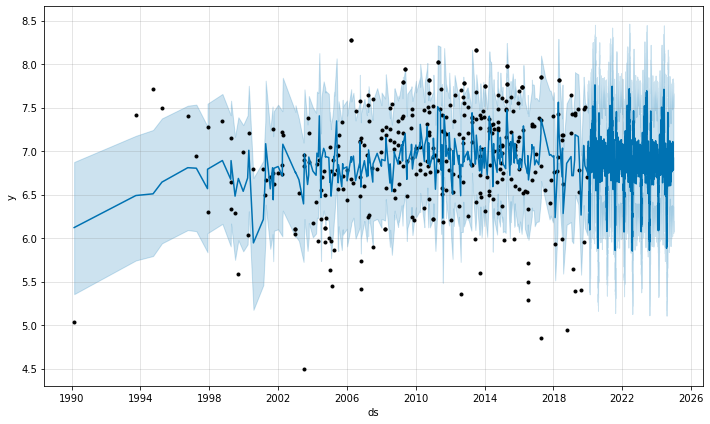

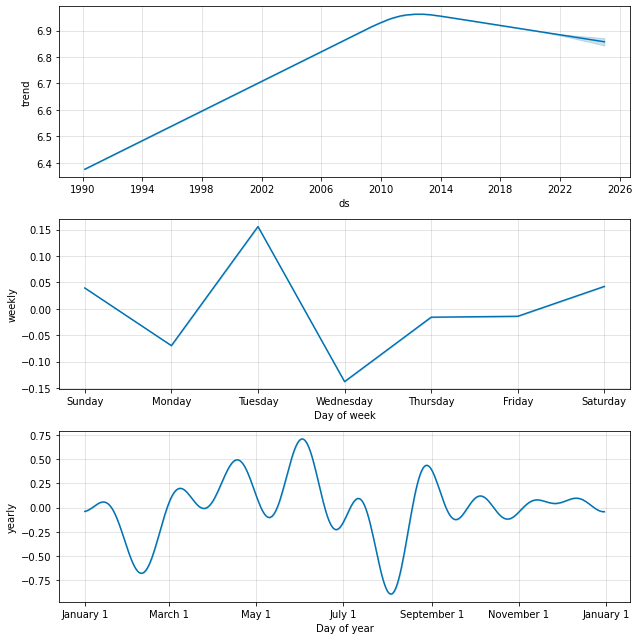

In [ ]:
print("Input a genre and how much years you would like to predict: ")
while True:
  Genre = input("Genre: ")
  if Genre in GenreDict:
    break
  print("Not a correct genre, try again")
Years = int(input("Years: "))*365

m, forecast = SingleProphet(GenreDict[Genre], Years)
fig1 = m.plot(forecast)
fig2 = m.plot_components(forecast)

# Basic Statistics Part

In [ ]:
BigGenreScoreDate = AnimeReviews[['genre','score_y','aired']].copy()
BigGenreDict = {}

for index,items in BigGenreScoreDate.iterrows():
  g = re.sub("'","",re.sub(" ","",items['genre'][1:-1])).split(',')
  if "" in g:
    g.remove("")
  j = convertDateTime(re.sub(" ","",re.split('to',items['aired'])[0]))
  data = {'ds':j, 'y':items['score_y']}
  df = pd.DataFrame(data, index=[0])
  for i in g:
    if i not in BigGenreDict:
      BigGenreDict[i] = df
    else:
      BigGenreDict.update({i:BigGenreDict[i].append(df, ignore_index=True)})

for i in BigGenreDict:
  BigGenreDict[i].sort_values(by=['ds'],inplace=True)

Input a genre and how much years you would like to predict: 
Genre: Thriller
Years: 2018


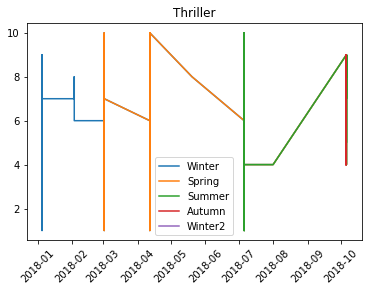

Winter: 786
Winter mean: 7.092875318066158
Spring: 731
Spring mean: 7.235294117647059
Summer: 103
Summer mean: 6.194174757281553
Autumn: 11
Autumn mean: 7.7272727272727275
Total: 1631
Total mean: 7.092875318066158
F value: 5.007596580105691
P value: 0.0018525039505845596


In [ ]:
print("Input a genre and how much years you would like to predict: ")
while True:
  Genre = input("Genre: ")
  if Genre in BigGenreDict:
    break
  print("Not a correct genre, try again")
Years = int(input("Years: "))

SeasonalBreakdown(BigGenreDict[Genre], Years, Genre)